In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(ACGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        
        # Input: latent_dim + num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.img_channels, 64, 64)
        return img


In [3]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(ACGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(img_channels * 64 * 64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128, num_classes), nn.Softmax(dim=1))

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        features = self.model(img_flat)
        
        # Discriminator output: real/fake
        validity = self.adv_layer(features)
        
        # Auxiliary output: class labels
        label = self.aux_layer(features)

        return validity, label


In [4]:
# Hyperparameters
latent_dim = 100
num_classes = 6
img_channels = 3
learning_rate = 0.0002
batch_size = 20

# Initialize generator and discriminator
generator = ACGANGenerator(latent_dim, num_classes, img_channels)
discriminator = ACGANDiscriminator(img_channels, num_classes)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()


In [5]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])

# Load dataset using ImageFolder
base_dir = 'DIAT-uSAT_dataset'  # Make sure this path is correct
dataset = ImageFolder(base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


In [6]:
num_epochs = 20
best_g_loss = float('inf')  # Initialize best generator loss as infinity

for epoch in range(num_epochs):
    total_g_loss = 0.0
    total_d_loss = 0.0
    num_batches = len(dataloader)
    
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.size(0)
        valid = torch.ones((batch_size, 1), requires_grad=False)
        fake = torch.zeros((batch_size, 1), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))

        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)

        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_pred, real_aux = discriminator(imgs)
        d_real_loss = (0.5 * (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)))

        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (0.5 * (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)))

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    # Calculate average losses for the epoch
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss = total_d_loss / num_batches

    # Print the average losses per epoch
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

    # Save the generator if the current epoch's generator loss is the lowest
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        torch.save(generator.state_dict(), "best_generator_model.pt")  # Save to the same file

[Epoch 1/20] [D loss: 0.9927] [G loss: 1.2093]
[Epoch 2/20] [D loss: 0.9413] [G loss: 1.0789]
[Epoch 3/20] [D loss: 0.9175] [G loss: 1.0386]
[Epoch 4/20] [D loss: 0.9060] [G loss: 1.0504]
[Epoch 5/20] [D loss: 0.9036] [G loss: 0.9992]
[Epoch 6/20] [D loss: 0.8986] [G loss: 0.9944]
[Epoch 7/20] [D loss: 0.8927] [G loss: 0.9880]
[Epoch 8/20] [D loss: 0.8861] [G loss: 0.9990]
[Epoch 9/20] [D loss: 0.8912] [G loss: 0.9852]
[Epoch 10/20] [D loss: 0.8897] [G loss: 0.9841]
[Epoch 11/20] [D loss: 0.8943] [G loss: 0.9838]
[Epoch 12/20] [D loss: 0.8924] [G loss: 0.9797]
[Epoch 13/20] [D loss: 0.8967] [G loss: 0.9734]
[Epoch 14/20] [D loss: 0.9015] [G loss: 0.9634]
[Epoch 15/20] [D loss: 0.8998] [G loss: 0.9680]
[Epoch 16/20] [D loss: 0.8977] [G loss: 0.9649]
[Epoch 17/20] [D loss: 0.9007] [G loss: 0.9620]
[Epoch 18/20] [D loss: 0.8989] [G loss: 0.9505]
[Epoch 19/20] [D loss: 0.8972] [G loss: 0.9508]
[Epoch 20/20] [D loss: 0.8946] [G loss: 0.9527]


Generator is on device: cuda:0
Noise is on device: cuda:0
Labels are on device: cuda:0
Generated images shape: torch.Size([6, 3, 64, 64])
Grid shape: torch.Size([3, 68, 398])


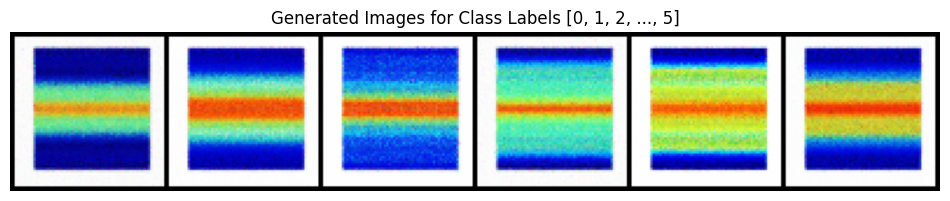

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def test_generator(generator, num_classes, latent_dim, device):
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise and class labels
    z = torch.randn(num_classes, latent_dim).to(device)  # Generate noise
    labels = torch.arange(num_classes).to(device)  # Class labels [0, 1, 2, ..., num_classes-1]
    
    # Move the generator to the specified device (if it's not already there)
    generator = generator.to(device)
    
    # Debugging: Check the device
    print(f"Generator is on device: {next(generator.parameters()).device}")
    print(f"Noise is on device: {z.device}")
    print(f"Labels are on device: {labels.device}")
    
    # Generate images
    with torch.no_grad():  # No need to compute gradients during testing
        gen_imgs = generator(z, labels)
    
    # Debugging: Print shape of generated images
    print(f"Generated images shape: {gen_imgs.shape}")
    
    # Unnormalize the images from [-1, 1] back to [0, 1] for visualization
    gen_imgs = (gen_imgs + 1) / 2.0
    
    # Create a grid of images and display them
    grid = make_grid(gen_imgs.cpu(), nrow=num_classes, normalize=False)
    
    # Debugging: Check grid shape
    print(f"Grid shape: {grid.shape}")
    
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images for Class Labels [0, 1, 2, ..., {num_classes-1}]")
    plt.axis("off")
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_generator(generator, num_classes=6, latent_dim=100, device=device)

In [10]:
import torch

def test_discriminator(discriminator, generator, dataloader, num_classes, latent_dim, device):
    # Set the models to evaluation mode
    discriminator = discriminator.to(device)  # Move discriminator to the correct device
    generator = generator.to(device)  # Move generator to the correct device
    
    discriminator.eval()
    generator.eval()

    # Initialize lists to store accuracy for real and fake images
    real_accuracy = 0
    fake_accuracy = 0
    class_accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.size(0)
            total_samples += batch_size

            imgs = imgs.to(device)
            labels = labels.to(device)
            real_pred, real_aux = discriminator(imgs)
            real_accuracy += (real_pred > 0.5).float().mean().item()  # Binary classification for real/fake
            class_accuracy += (real_aux.argmax(dim=1) == labels).float().mean().item()  # Class accuracy

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)

            fake_pred, fake_aux = discriminator(gen_imgs)
            fake_accuracy += (fake_pred < 0.5).float().mean().item()  # Fake should be classified as 0 (fake)
            class_accuracy += (fake_aux.argmax(dim=1) == gen_labels).float().mean().item()

    # Calculate average accuracies
    real_accuracy /= len(dataloader)
    fake_accuracy /= len(dataloader)
    class_accuracy /= (2 * len(dataloader))  # Since class accuracy is measured for both real and fake

    print(f"Discriminator Real Accuracy: {real_accuracy * 100:.2f}%")
    print(f"Discriminator Fake Accuracy: {fake_accuracy * 100:.2f}%")
    print(f"Discriminator Class Accuracy: {class_accuracy * 100:.2f}%")

# Example usage 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_discriminator(discriminator, generator, dataloader, num_classes=6, latent_dim=100, device=device)



Discriminator Real Accuracy: 34.00%
Discriminator Fake Accuracy: 83.29%
Discriminator Class Accuracy: 92.52%
